# Dave's One Bite Pizza Review EDA

In [72]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from twitterscraper import query_tweets
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
import json
pd.set_option('display.max_rows',None)
MY_API_KEY = "dp7VH5EtI-KUoL1V4OiKGvrkQow1HjxTqbBgZ2AGpYRMlm3lRTvuxysK130iuGpJCprLbqFd8edYira566HVCTzWZx64V_q6eL9mzEfnU9p04rRk1YTsopZ-GhlAX3Yx" #  Replace this with your real API key

In [36]:
df = pd.read_csv('pizza_data_clean.csv') # I have already cleaned my webscraped csv
df['Date'] = pd.to_datetime(df['Date'])
df.head() # Currently 846 rows and 6 columns shown below

,Company Name,State,Rating,Date,Time,Url
0,Fierro's Pizza,NY 11937,7.4,2020-08-19,6:00,https://onebite.app/restaurant/fierros-pizza-e...
1,Springs Pizza,NY 11937,5.8,2020-08-18,6:00,https://onebite.app/restaurant/springs-pizza-e...
2,Pepperoni's,NY 11937,6.7,2020-08-17,6:00,https://onebite.app/restaurant/pepperonis-east...
3,Astro's Pizza,NY 11930,6.8,2020-08-13,6:00,https://onebite.app/restaurant/astros-pizza-am...
4,Best Pizza & Dive Bar,NY 11930,8.4,2020-08-12,6:00,https://onebite.app/restaurant/best-pizza-and-...


### What other factors could be interesting to explore?
* If pizza is in the name
* How long the name is
* What sport season it is (Dave is a big sports fan)
* What actual season it is
* Days since last review
* Last 3 scores average
* Last 10 scores aerage
* Last score
* Yelp rating of pizza joint
* Number of Yelp reviews of pizza joint
* Yelp Price of Pizza
* sentiment score avg of his past 10 tweets

In [37]:
def findSeason(x):
    if (dt.datetime(x.year, 12, 21)  <= x and x <= dt.datetime(x.year, 12, 31)) or (
        dt.datetime(x.year, 1, 1) <= x and x <= dt.datetime(x.year, 3, 20)):
        return 'winter'
    elif dt.datetime(x.year-1, 3, 21)  <= x  and x <= dt.datetime(x.year, 6, 20):
        return 'spring'
    elif dt.datetime(x.year-1, 6, 21)  <= x  and x <= dt.datetime(x.year, 9, 20):
        return 'summer'
    else:
        return 'fall'

def footballSeason(x):
    if (dt.datetime(x.year, 9, 15)  <= x and x <= dt.datetime(x.year, 12, 31)) or (
        dt.datetime(x.year, 1, 1) <= x and x <= dt.datetime(x.year, 2, 20)):
        return 1
    return 0

def basketballSeason(x):
    if (dt.datetime(x.year, 10, 15)  <= x and x <= dt.datetime(x.year, 12, 31)) or (
        dt.datetime(x.year, 1, 1) <= x and x <= dt.datetime(x.year, 6, 15)):
        return 1
    return 0

def baseballSeason(x):
    if (dt.datetime(x.year, 3, 29)  <= x and x <= dt.datetime(x.year, 10, 20)):
        return 1
    return 0


analyzer = SentimentIntensityAnalyzer()
df['pizza_name_yn'] = df["Company Name"].apply(lambda x: 1 if "pizza" in x.lower() else 0)
df['name_length'] = df["Company Name"].apply(lambda x: len(x))
df['basketball_season_yn'] = df['Date'].apply(basketballSeason)
df['football_season_yn'] = df['Date'].apply(footballSeason)
df['baseball_season_yn'] = df['Date'].apply(baseballSeason)
df['season'] = df['Date'].apply(findSeason)

,Company Name,State,Rating,Date,Time,Url,pizza_name_yn,name_length,basketball_season_yn,football_season_yn,baseball_season_yn,season
0,Fierro's Pizza,NY 11937,7.4,2020-08-19,6:00,https://onebite.app/restaurant/fierros-pizza-e...,1,14,0,0,1,summer
1,Springs Pizza,NY 11937,5.8,2020-08-18,6:00,https://onebite.app/restaurant/springs-pizza-e...,1,13,0,0,1,summer
2,Pepperoni's,NY 11937,6.7,2020-08-17,6:00,https://onebite.app/restaurant/pepperonis-east...,0,11,0,0,1,summer
3,Astro's Pizza,NY 11930,6.8,2020-08-13,6:00,https://onebite.app/restaurant/astros-pizza-am...,1,13,0,0,1,summer
4,Best Pizza & Dive Bar,NY 11930,8.4,2020-08-12,6:00,https://onebite.app/restaurant/best-pizza-and-...,1,21,0,0,1,summer


In [38]:
for i,d in df.iterrows():
    try:
        df.loc[i,'Days_Since'] = (df.loc[i, 'Date'] - df.loc[i+1,'Date']).days
    except:
        df.loc[i,'Days_Since'] = np.nan
    try:
        df.loc[i, 'Last_Score'] = df.loc[i+1, "Rating"]
    except:
        df.loc[i, 'Last_Score'] = np.nan
    try:
        df.loc[i, 'Three_Day_Avg'] = (df.loc[i+1, "Rating"]+df.loc[i+2, "Rating"]+df.loc[i+3, "Rating"])/3
    except:
        df.loc[i, 'Three_Day_Avg'] = np.nan
    try:
        df.loc[i, 'Ten_Day_Avg'] = (df.loc[i+1, "Rating"]+df.loc[i+2, "Rating"]+df.loc[i+3, "Rating"]
                                +df.loc[i+4, "Rating"]+df.loc[i+5, "Rating"]+df.loc[i+6, "Rating"]
                                +df.loc[i+7, "Rating"]+df.loc[i+8, "Rating"]+df.loc[i+9, "Rating"]
                                +df.loc[i+10, "Rating"])/10
    except:
        df.loc[i, 'Ten_Day_Avg'] = np.nan

In [39]:
def getYelpReview(x):
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': f'Bearer {MY_API_KEY}'}
    params = {'term':x['Company Name'],'location':x['State']}
    req=requests.get(url, params=params, headers=headers)
    data = json.loads(req.text)
    try:
        business = data['businesses'][0]
        return business['review_count'], business['rating'], len(business['price'])
    except:
        return np.nan, np.nan, np.nan
    

In [40]:
# This will take awhile.
df['num_yelp_reviews'], df['yelp_rating'], df['yelp_est_price'] = zip(*df.apply(getYelpReview, axis=1))

In [41]:
df['Zip'] = df['State'].apply(lambda x: x[2:])
df['State'] = df['State'].apply(lambda x: x[:2])

In [42]:
# This will take even longer
# We will Skip This For now
# def tweetSentiment(x):
#     end_date = x.date()
#     begin_date = (x-dt.timedelta(days=1)).date()
#     lang = 'english'
#     user = 'stoolpresidente'
#     tweets = query_tweets(user, begindate=begin_date, enddate=end_date,lang=lang, limit=10)
#     temp = pd.DataFrame(t.__dict__ for t in tweets)
#     if len(temp) == 0:
#         return np.nan
#     temp.drop_duplicates(subset='text', inplace=True)
#     sentiment = temp['text'].apply(lambda x: analyzer.polarity_scores(x))
#     try:
#         return sentiment['compound'].mean()
#     except:
#         return np.nan
    
# for i,d in df.iterrows():
#     df.loc[i,'past_day_avg_sentiment'] = tweetSentiment(df.loc[i,'Date'])

## Now That we Have Our Data Lets Explore

In [43]:
# Get a general overview of what our data looks like
df.describe()

,Rating,pizza_name_yn,name_length,basketball_season_yn,football_season_yn,baseball_season_yn,Days_Since,Last_Score,Three_Day_Avg,Ten_Day_Avg,num_yelp_reviews,yelp_rating,yelp_est_price
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,845.000000,845.000000,843.000000,836.000000,782.000000,782.000000,782.000000
mean,6.619740,0.495272,17.166667,0.656028,0.451537,0.557920,3.214201,6.618817,6.617003,6.608660,422.705882,3.732097,1.593350
std,1.767578,0.500273,7.245933,0.475313,0.497940,0.496928,19.470911,1.768421,1.060414,0.622232,741.921503,0.524831,0.552825
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,4.470000,1.000000,1.000000,1.000000
25%,6.200000,0.000000,12.000000,0.000000,0.000000,0.000000,1.000000,6.200000,6.100000,6.230000,93.000000,3.500000,1.000000
50%,7.100000,0.000000,16.000000,1.000000,0.000000,1.000000,1.000000,7.100000,6.800000,6.625000,193.500000,4.000000,2.000000
75%,7.700000,1.000000,21.000000,1.000000,1.000000,1.000000,2.000000,7.700000,7.366667,7.060000,425.000000,4.000000,2.000000
max,10.000000,1.000000,46.000000,1.000000,1.000000,1.000000,487.000000,10.000000,8.833333,8.200000,6201.000000,5.000000,4.000000


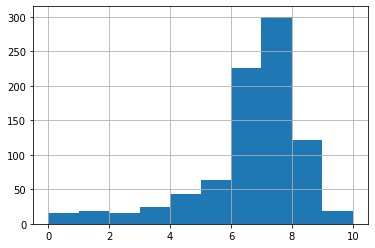

In [44]:
# Taking Ccoser Looks at columns
df.Rating.hist()

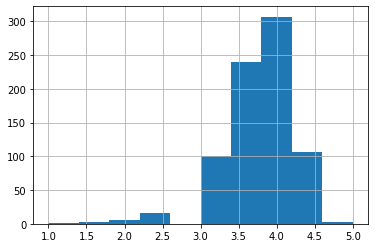

In [45]:
df.yelp_rating.hist()

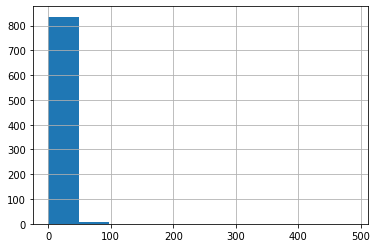

In [89]:
df.Days_Since.hist()

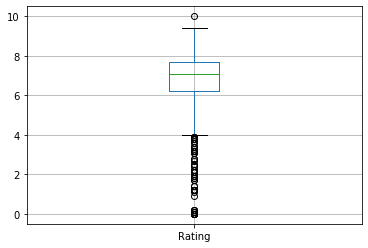

In [47]:
df.boxplot(column = 'Rating')

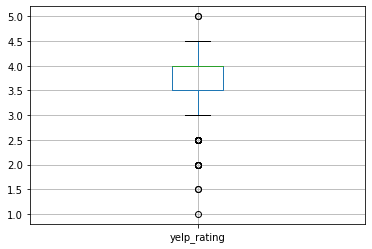

In [48]:
df.boxplot(column = 'yelp_rating')

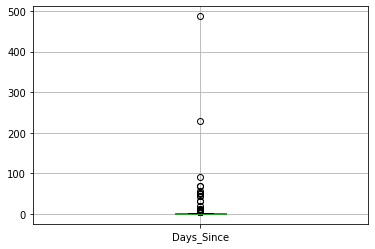

In [49]:
df.boxplot(column = 'Days_Since')

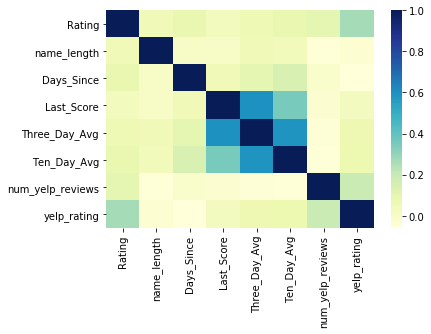

,Rating,name_length,Days_Since,Last_Score,Three_Day_Avg,Ten_Day_Avg,num_yelp_reviews,yelp_rating
Rating,1.000000,0.049186,0.087456,0.036080,0.060794,0.082575,0.105405,0.271321
name_length,0.049186,1.000000,0.005323,0.003169,0.054365,0.041135,-0.050214,-0.034205
Days_Since,0.087456,0.005323,1.000000,0.052265,0.104276,0.144367,-0.015864,-0.059052
Last_Score,0.036080,0.003169,0.052265,1.000000,0.600711,0.354062,-0.026830,0.030765
Three_Day_Avg,0.060794,0.054365,0.104276,0.600711,1.000000,0.593873,-0.044622,0.066451
Ten_Day_Avg,0.082575,0.041135,0.144367,0.354062,0.593873,1.000000,-0.048984,0.075369
num_yelp_reviews,0.105405,-0.050214,-0.015864,-0.026830,-0.044622,-0.048984,1.000000,0.190876
yelp_rating,0.271321,-0.034205,-0.059052,0.030765,0.066451,0.075369,0.190876,1.000000


In [90]:
corr_nums = df[['Rating','name_length','Days_Since','Last_Score',
                'Three_Day_Avg', 'Ten_Day_Avg', 'num_yelp_reviews', 'yelp_rating']].corr()
sns.heatmap(corr_nums, cmap="YlGnBu")
plt.show()
corr_nums

Graph for pizza_name_yn. Total = 2


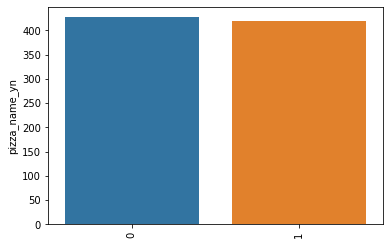

Graph for basketball_season_yn. Total = 2


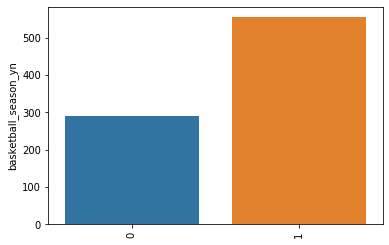

Graph for football_season_yn. Total = 2


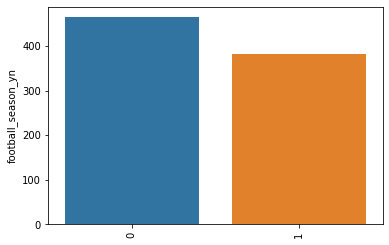

Graph for baseball_season_yn. Total = 2


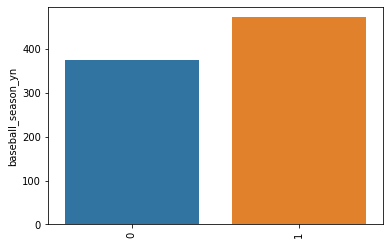

Graph for season. Total = 4


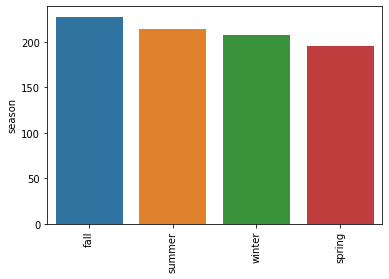

Graph for yelp_est_price. Total = 4


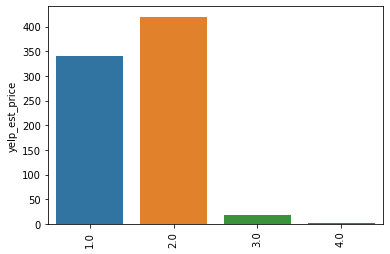

Graph for State. Total = 29


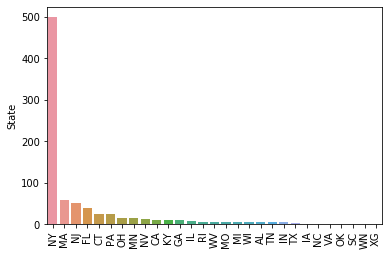

In [56]:
df_cat = df[['pizza_name_yn', 'basketball_season_yn',
       'football_season_yn', 'baseball_season_yn', 'season','yelp_est_price','State']]
for i in df_cat.columns:
    cat_num = df_cat[i].value_counts()
    print(f"Graph for {i}. Total = {len(cat_num)}")
    chart = sns.barplot(x=cat_num.index, y=cat_num)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

In [94]:
by_state = pd.pivot_table(df, index='State', values='Rating')
count_by_state = pd.pivot_table(df, index='State', values='Rating', aggfunc='count')
count_by_state.rename(columns={'Rating':'Counts'}, inplace=True)
by_state = by_state.merge(count_by_state, on='State')
by_state.sort_values(by='Rating', ascending=False)

,Rating,Counts
State,,
CT,7.557692,26
OK,7.500000,1
NJ,7.284615,52
PA,7.104000,25
VA,7.100000,1
SC,7.100000,1
RI,6.985714,7
MA,6.974138,58
TN,6.900000,5


In [73]:
by_state_season = pd.pivot_table(df, index=['State','season'], values='Rating')
by_state_season.sort_values(by='Rating', ascending=False)

,,Rating
State,season,
CT,fall,8.400000
MN,summer,8.300000
MA,winter,8.200000
NJ,fall,7.850000
CT,spring,7.825000
CA,winter,7.800000
MA,spring,7.783333
PA,summer,7.623529
MI,winter,7.600000


In [93]:
by_price = pd.pivot_table(df, index='yelp_est_price', values='Rating')
count_by_price = pd.pivot_table(df, index='yelp_est_price', values='Rating', aggfunc='count')
count_by_price.rename(columns={'Rating':'Counts'}, inplace=True)
by_price = by_price.merge(count_by_price, on='yelp_est_price')
by_price.sort_values(by='yelp_est_price', ascending=False)

,Rating,Counts
yelp_est_price,,
4.0,7.450000,2
3.0,6.205263,19
2.0,6.898571,420
1.0,6.451320,341


In [87]:
by_price = pd.pivot_table(df, index='Days_Since', values='Rating')
count_by_price = pd.pivot_table(df, index='Days_Since', values='Rating', aggfunc='count')
count_by_price.rename(columns={'Rating':'Counts'}, inplace=True)
by_price = by_price.merge(count_by_price, on='Days_Since')
by_price.sort_values(by='Days_Since')

,Rating,Counts
Days_Since,,
0.0,6.588462,26
1.0,6.558834,566
2.0,6.520370,54
3.0,6.662500,112
4.0,7.033333,42
5.0,6.709091,11
6.0,7.322222,9
7.0,5.400000,4
8.0,8.200000,2


# Interesting Data Points
### Yelp Rating and Dave's Rating are the highest corrolated
* This makes sense as people have similar taste
* Also there is a slight corralation between number of reviews and rating
### The number of pizza resteraunts that have pizza in their name is about 50%
### The Last Score and Last 3 Scores and Last 10 scores are not that coorolated to the current rating
* This goes against my beleive as I figured the more frequently he is having good pizza the harsher of a reviewer he would be
### Days since last review is also not heavily correlated with rating
* I again thought as the longer time passed between each review the more suseptible he would be to a higher review
### The mean review is a 6.6 and the median is 7.1
* the reviews are skewed left
### He enjoys CT pizza the most
### Most Pizza is in the 1 or 2 price category on yelp
* rougly 97% of the places he reviewed
### Most pizza reviews are daily, almost all are within a week

